# Titanic with decision trees and random forests

Here I intend to explore and learn more about decision trees and random forests by participating in the Kaggle competition https://www.kaggle.com/c/titanic. I am also learning more about general methods to improve classification performance such as K-fold cross validation, bagging and good practices on how to deal with missing data. My Kaggle profile is https://www.kaggle.com/gurbraj. This is a playground where I try to get a feel for the different components that goes in to a project of this sort. I am well aware that making many submissions is not good practice.   

My workflow is: 

    -Study some theory of how these algorithms work 
        - Some of the sources I use: 
            https://www.youtube.com/watch?v=LDRbO9a6XPU
            http://people.ischool.berkeley.edu/~hal/Papers/2013/ml.pdf
        
    -Implement algorithm without external library and consulting theory as little as possible 
        -this is meant more as a sketch to make sure I understand the underlying mechanisms of the algorithm.
  
    - Work with algorithm through scikit learn
        - get to know the library
    
         
      

In [4]:
#setup kaggle cli by using 
#kg config -g -u $USER -p $PASSWoRD -c titanic
#kg download

In [5]:
import pandas as pd

In [6]:
data = pd.read_csv('data/train.csv')

In [7]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


I'll start by just using age and sex as features.

In [8]:
X_df = data[['Age', 'Sex', 'PassengerId']]
Y_df = data[ ['Survived', 'PassengerId']]

In [9]:
X_df = X_df.set_index('PassengerId')
Y_df = Y_df.set_index('PassengerId')

In [10]:
X_df.head()

,Age,Sex
PassengerId,,
1,22.0,male
2,38.0,female
3,26.0,female
4,35.0,female
5,35.0,male


In [11]:
Y_df.head()

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


In [12]:
class Question:

    def __init__(self, question_type, value):
        self.question_type = question_type
       
        self.value = value
        

    def __repr__(self):
        
        if self.question_type =="Age" :
            return "Age >= {} ?".format(self.value)
        elif self.question_type == "Sex":
            return "Sex == {} ?".format(self.value)
        
    def match(self, passenger):
        #passenger will be a DataFrame row
        if self.question_type =="Age" :
            return passenger.Age >= self.value
        elif self.question_type == "Sex":
            return self.value == passenger.Sex

Some demos below to see that it works as intended.

In [13]:
q_age = Question("Age",1)

In [14]:
q_age

Age >= 1 ?

In [15]:
q_sexm = Question("Sex", "male")

In [16]:
q_sexm

Sex == male ?

In [17]:
passenger_m22 = X_df.ix[1]

In [18]:
passenger_m22

Age      22
Sex    male
Name: 1, dtype: object

In [19]:
q_age.match(passenger_m22)

True

In [21]:
q_age23 = Question("Age",23)
q_age23.match(passenger_m22)

False

In [22]:
q_sexm.match(passenger_m22)

True

Create measure of impurity 

In [23]:
def gini_impurity_function(Y_df):
    unique_values = Y_df.Survived.unique()
    #will be 0 (died) or 1 (survived)  
    died_count = Y_df[Y_df==0].count()
    survived_count = Y_df[Y_df==1].count()
    total_count = Y_df.count()
    
    result = 1 - (survived_count/total_count)**2 - (died_count/total_count)**2
    return result[0]
    

In [24]:
gini_impurity_function(Y_df)

0.47301295786144276

In [25]:
gini_impurity_function(Y_df[Y_df==1])

0.0

Seems like it works.

Now, for a given question, find the passengers for which that question is true and then false

In [26]:
def partitioner(question, X_df):
    
    true_passengers = []
    false_passengers = []
    
    
    for passenger in X_df.itertuples():
        if question.match(passenger):
            true_passengers.append(passenger[0])
            #print(question ,passenger)
        else:
            #print("did not match", passenger)
            false_passengers.append(passenger[0])
            
            
    #turn arrays (that contain ID_s into DF's)        
    true_passengers = pd.DataFrame(data={"PassengerId": true_passengers})        
    false_passengers = pd.DataFrame(data={"PassengerId": false_passengers})
    
    true_passengers_df = X_df.merge(true_passengers, how='inner', left_index=True, right_on='PassengerId').set_index('PassengerId')
    false_passengers_df = X_df.merge(false_passengers, how='inner', left_index=True, right_on='PassengerId').set_index('PassengerId')        
    return true_passengers_df, false_passengers_df        

In [28]:
true_passengers_df, false_passengers_df = partitioner(q_age23, X_df)

In [29]:
true_passengers_df.head()

,Age,Sex
PassengerId,,
2,38.0,female
3,26.0,female
4,35.0,female
5,35.0,male
7,54.0,male


plan for finding the best split: 
    1) ask all possible questions
    2) find out which one gives the best information gain and pick that question.

In [30]:
def find_best_split(X_df, Y_df ):
    

    
    
    ages = X_df.Age.unique()
    sexes = X_df.Sex.unique()
    
    gini_impurity = gini_impurity_function(Y_df)
    
    information_gain_age_max = 0
    information_gain_sex_max = 0
    
    age_question_max = ages[0]
    sex_question_max = sexes[0]
    
    for age in ages:
        age_question = Question("Age", age)
        
        true_passengers_df, false_passengers_df = partitioner(age_question, X_df)
        
        if len(true_passengers_df)==0 or len(false_passengers_df) ==0 :
            continue
        
        Y_df_of_true_passengers = Y_df.merge(true_passengers_df, how='inner', left_index=True, right_index=True)['Survived'].to_frame()
        #now need to do
        Y_df_of_false_passengers = Y_df.merge(false_passengers_df, how='inner', left_index=True, right_index=True)['Survived'].to_frame()
        
        true_passengers_fraction = len(true_passengers_df) / (len(true_passengers_df) + len(false_passengers_df))
        
        gini_impurity_post_split = true_passengers_fraction * gini_impurity_function(Y_df_of_true_passengers ) + (1 - true_passengers_fraction) * gini_impurity_function(Y_df_of_false_passengers )
        
        information_gain_age = gini_impurity - gini_impurity_post_split
        
        if  information_gain_age > information_gain_age_max:
            information_gain_age_max = information_gain_age
            age_question_max = age_question
            
    #for sex        
    for sex in sexes:
        sex_question = Question("Sex", sex)
        
        true_passengers_df, false_passengers_df = partitioner(sex_question, X_df)
        
        if len(true_passengers_df)==0 or len(false_passengers_df) ==0 :
            continue
        
        Y_df_of_true_passengers = Y_df.merge(true_passengers_df, how='inner', left_index=True, right_index=True)['Survived'].to_frame()
        #now need to do
        Y_df_of_false_passengers = Y_df.merge(false_passengers_df, how='inner', left_index=True, right_index=True)['Survived'].to_frame()
        
        true_passengers_fraction = len(true_passengers_df) / (len(true_passengers_df) + len(false_passengers_df))
        
        gini_impurity_post_split = true_passengers_fraction * gini_impurity_function(Y_df_of_true_passengers ) + (1 - true_passengers_fraction) * gini_impurity_function(Y_df_of_false_passengers )
        
        information_gain_sex = gini_impurity - gini_impurity_post_split
        
        if information_gain_sex > information_gain_sex_max:
            information_gain_sex_max = information_gain_sex 
            sex_question_max = sex_question
    
    
    #compare and return best question.
    
    if information_gain_sex_max > information_gain_age_max:
        return information_gain_sex_max, sex_question_max
    else: 
        return information_gain_age_max, age_question_max
        

In [31]:
information_gain, question = find_best_split(X_df, Y_df)

In [32]:
question

Sex == male ?

In [33]:
information_gain

0.13964795747285236

Since most information is gained from the sex question this question will be the first one asked.

Also makes sense that sex should be a big contributor to who gets to live and who gets to die. No room for the disposable man on the life boats.

In [34]:
class Leaf:

    def __init__(self, question):
        self.question = question

In [35]:
class Node:
    # node will have a question, and the partition that arise from dividing on that question at that location.
    def __init__(self, question, true_passengers, false_passengers):
        self.question = question
        self.true_passengers = true_passengers
        self.false_passengers = false_passengers

In [36]:
def train_tree(X_df, Y_df):
    
    information_gain, question = find_best_split(X_df, Y_df)
    print(question, information_gain)
    
    if information_gain == 0:
         return Leaf(question)
        
        
        
    true_passengers_df, false_passengers_df = partitioner(question, X_df)
    
    Y_df_of_true_passengers = Y_df.merge(true_passengers_df, how='inner', left_index=True, right_index=True)['Survived'].to_frame()
        
    Y_df_of_false_passengers = Y_df.merge(false_passengers_df, how='inner', left_index=True, right_index=True)['Survived'].to_frame()
    
    train_tree(true_passengers_df, Y_df_of_true_passengers)
    
    train_tree(false_passengers_df, Y_df_of_false_passengers)
    
    return Node(question, true_passengers_df, false_passengers_df)

In [37]:
last_node = train_tree(X_df, Y_df)

Sex == male ? 0.139647957473
Age >= 80.0 ? 0.00228427082051
80.0 0
Age >= 0.42 ? 0.00187562446474
Age >= 7.0 ? 0.0240545577551
Age >= 25.0 ? 0.00269327692059
Age >= 54.0 ? 0.00402639108571
Age >= 64.0 ? 0.00694444444444
66.0 0
Age >= 56.0 ? 0.0128676470588
Age >= 62.0 ? 0.0105453946284
62.0 0
Age >= 57.0 ? 0.0197897340754
Age >= 60.0 ? 0.0137741046832
Age >= 61.0 ? 0.0555555555556
61.0 0
60.0 0
59.0 0
56.0 0
54.0 0
Age >= 28.0 ? 0.00277561926008
Age >= 48.0 ? 0.00434835849309
Age >= 50.0 ? 0.0592592592593
Age >= 52.0 ? 0.00181818181818
52.0 0
Age >= 51.0 ? 0.000550964187328
51.0 0
50.0 0
Age >= 49.0 ? 0.00493827160494
49.0 0
48.0 0
Age >= 45.5 ? 0.00472627474382
46.0 0
Age >= 31.0 ? 0.00409187758264
Age >= 32.5 ? 0.0146022167021
Age >= 34.0 ? 0.00731778759564
Age >= 45.0 ? 0.00229645843051
45.0 0
Age >= 36.5 ? 0.00338735882137
Age >= 42.0 ? 0.00312937181664
Age >= 43.0 ? 0.0177900892582
Age >= 44.0 ? 0.0123456790123
44.0 0
43.0 0
42.0 0
Age >= 40.5 ? 0.00493313292481
40.5 0
Age >= 37.0

# Implementation using Sklearn 

I start by just using the features Sex and Age

In [39]:
from sklearn import tree
import numpy as np

For the SK-learn algo to work, I need to encode sex. Note that I'm working by modifying the already existent X_df

In [40]:
#X_df_copy = X_df.copy()
X_df.Sex = X_df.Sex.apply(lambda sex: 1 if sex=='male' else 0)

### Handle missing values

One way of handling missing values is simply just to remove them. Another way is to use the mean (or mode if it is categorial, variable) conditional on the other features. 

EX: if sex is missing, but age is K then choose according to max(# females age K, # males age K)

EX: if age is missing, but sex is male, then choose   age mean for the male population

I'll choose the latter as data is scarce and i have no idea of why the data is missing. 

my (incomplete) thoughts around this are that:

If the distribution of the conditional data is symmetric around the mean, using the mean makes sense, as the mean is most likely to appear from a random draw.

If the distribution is not symmetric around the mean, using the mode makes sense.

when it comes to how reason for why the data missing comes into play (contrived example):
     maybe the passengers had to fill in a voluntary form of their age. one could argue that those that did not fill in the form are more careless than the others, and hence are not well represented by the conditional distributions

In [41]:
#X_df_copy = X_df_copy[np.isnan(X_df_copy.Age)==False]

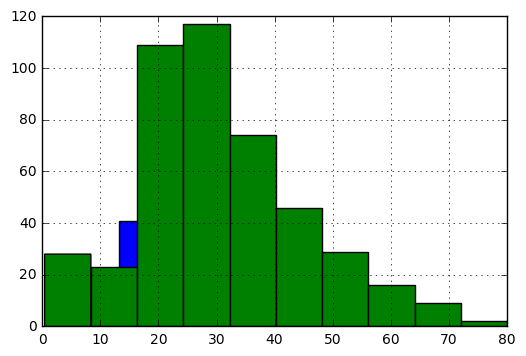

In [42]:
import matplotlib.pyplot as plt

X_df_group_sex = X_df.groupby(['Sex'])['Age']
#   ;p
X_df_group_sex.hist()
plt.show()

An visual inspection shows that it is roughly normal distributed (and hence symmetric around the mean)

In [43]:
X_df_group_sex = X_df_group_sex.mean().to_frame()
X_df_group_sex.Age = X_df_group_sex.Age.apply(lambda age: round(age))

In [44]:
X_df_group_sex


,Age
Sex,
0,28
1,31


In [45]:
def compensated_age_inner_join(X_df, c_d_on = ['Sex']):
    X_df_group_sex = X_df.groupby(c_d_on)['Age']
    X_df_group_sex = X_df_group_sex.mean().to_frame()
    #print(X_df_group_sex)
    X_df_group_sex.Age = X_df_group_sex.Age.apply(lambda age: round(age))
    
    compensated_age = pd.merge(X_df, X_df_group_sex, left_on=c_d_on, how="left", right_index=True).Age_y
    #print(compensated_age)
    
    return compensated_age
    

In [46]:
compensated_age = compensated_age_inner_join(X_df)

In [47]:
#this will put the values of passenger_compensated_age in the places that miss value. sort of like a inner join of age, on NaN 
X_df.Age = X_df.Age.fillna(compensated_age)

### Fitting and Interpretation

Just as a first approach, I'm setting the max_depth equal to the number of features 1) to prevent overfitting, 2) to get an easy interpretation



In [48]:
clf = tree.DecisionTreeClassifier(max_depth = 2)
#setting max_depth equal to the number of features. 1) to prevent overfitting, 2) to get a easy interpretation
clf = clf.fit(X_df.values, Y_df.values)

In [49]:
import graphviz 
dot_data = tree.export_graphviz(clf, feature_names=["Age", "Sex"], class_names=["Died", "Survived"], filled=True ,out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("titanic") 


'titanic.pdf'

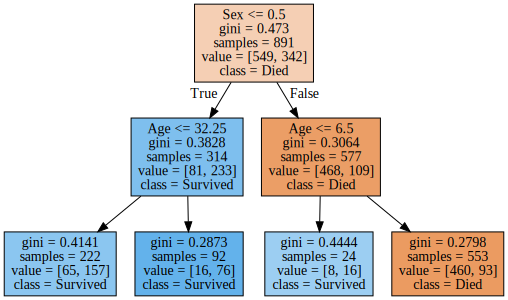

In [50]:
graph

For Males it will predict: If age is under 6.5, then live, else die

In [51]:
clf.predict([[6.5, 1]])

array([1])

In [52]:
clf.predict([[7, 1]])

array([0])

For Females it will predict: live, for all ages

In [53]:
clf.predict([[12, 0]])

array([1])

In [54]:
clf.predict([[122, 0]])

array([1])

This makes sense as 'Women and children first' was a policy for access to the life boats (Only source I have for this is the movie).

value represent the quantity of how many people died and lived, respectively, at each node of the tree.

#### Submission

I'll make one submission now with these settings, just to get one benchmark-score.



In [55]:
def prepare_submission(version, features_and_id=['Age', 'Sex', 'PassengerId']):
    
    test_data = pd.read_csv('data/test.csv')

    X_test_df = test_data[features_and_id]
    X_test_df = X_test_df.set_index('PassengerId')

    X_test_df.Sex = X_test_df.Sex.apply(lambda sex: 1 if sex=='male' else 0)
    
    compensated_age = compensated_age_inner_join(X_test_df)
    X_test_df.Age = X_test_df.Age.fillna(compensated_age)
    

    X_test_df['Prediction'] = clf.predict(X_test_df.values)

    X_test_df['Prediction'].to_csv('./data/gender_submission_{}.csv'.format(version), index_label=['PassengerId'] ,header=['Survived'])


In [56]:
prepare_submission(1)

then on kaggle CLI:   kg submit gender_submission.csv -u $user -p $password -c titanic

this submission gave a accuracy of 0.75598 and placement 6897 / 8368. Fairly decent accuracy I think on such a simple procedure. 

Next, I will proceed by doing more analysis and improvements, by experimenting.

In order to this, it is necessary to create a cross validation set.

discretization

more stuff here.

then random forest

## More features



In [57]:
Y_df = data[ ['Survived', 'PassengerId']]
Y_df = Y_df.set_index('PassengerId')

In [58]:

X_df_columns = data.columns.values 
#remove('Survived')
X_df_columns = np.delete(X_df_columns, 1)
X_df_columns

array(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

Remove features I think are irrelevant. Description of the features below.



pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation

In [59]:
#remove('Name')
X_df_columns = np.delete(X_df_columns, 2)
#remove('Ticket')
X_df_columns = np.delete(X_df_columns, 6)
#remove('Fare')
X_df_columns = np.delete(X_df_columns, 6)
#remove('Cabin')
X_df_columns = np.delete(X_df_columns, 6)
#remove('Embarked') 
X_df_columns = np.delete(X_df_columns, 6)
X_df_columns

array(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch'], dtype=object)

I think that pclass will be an important feature.


sibsp and parch are likely correlated. Is this a problem with decision trees?

In [60]:
X_df = data[X_df_columns]
X_df = X_df.set_index('PassengerId')

compensated_age = compensated_age_inner_join(X_df, ['Pclass', 'Sex','Parch'])

X_df.Age = X_df.Age.fillna(compensated_age)

Note here that the compensated age does not take  SibSp into account. The reason for this (I learned this the hard way...), is that there exists a female that has age NAN, but an unique value for SibSp, so the groupby operation will not be able to compute a compensated age for the female. In essence, the conditional distribution will not be defined for the unique value of SibSp.

Lesson is that whenever I'm handling missing errors by this method, then use compensated values on the maximum number of column namnes that does not generate any NAN values. 



In [61]:
X_df.Sex = X_df.Sex.apply(lambda sex: 1 if sex =='male' else 0)

## Discretize values

If there are a lot of unique values in the feature space, I have read that the decision tree can have a difficult time learning meaningful patterns. One way of mitigating this is to 'discretize' the values. I think of this as creating a histogram for each feature, and use the histogram-values instead of the feature values.  

In this particular case, Age has a lot of unique values.

In [62]:
len(X_df.Age.unique())

88

In [63]:
pd.qcut(X_df.Age, 10, retbins=True)[1]
def quantiles(series, k):
    #gives back the quantile values, k of them 
    return pd.qcut(series, k, retbins=True)[1]

def discretize(series, bins):
    return pd.cut(series, bins, labels=range(len(bins)-1), include_lowest=True)


X_df.Age = discretize(X_df.Age, quantiles(X_df.Age, 10))

In [64]:
len(X_df.Age.unique())

10

In [65]:
X_df.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'], dtype='object')

In [66]:
clf = tree.DecisionTreeClassifier(max_depth = 3)
#note this one has a larger max_depth
clf = clf.fit(X_df.values, Y_df.values)

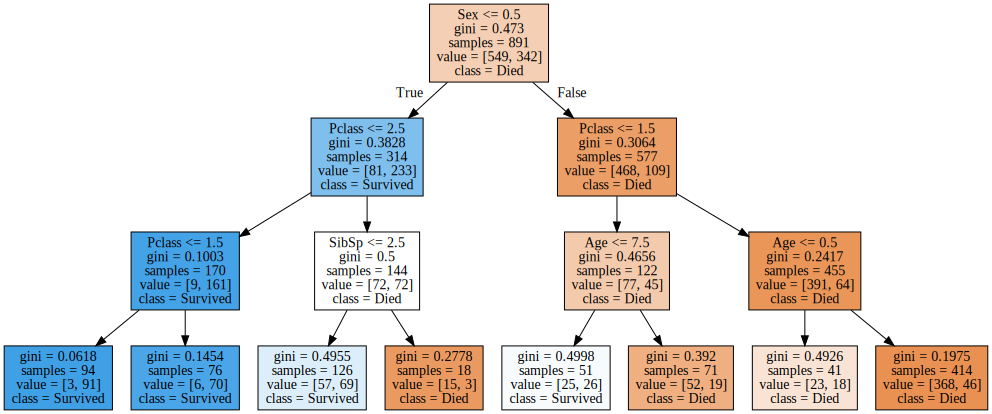

In [67]:
import graphviz 
dot_data = tree.export_graphviz(clf, feature_names=X_df.columns.values, class_names=["Died", "Survived"], filled=True ,out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("titanic") 
graph

In [68]:
def prepare_submission_with_discretization(version, features_and_id=['Age', 'Sex', 'PassengerId']):
    #only change ive made here from prepare_submission is that i discretize
    
    test_data = pd.read_csv('data/test.csv')

    X_test_df = test_data[features_and_id]
    X_test_df = X_test_df.set_index('PassengerId')

    X_test_df.Sex = X_test_df.Sex.apply(lambda sex: 1 if sex=='male' else 0)
    
    compensated_age = compensated_age_inner_join(X_test_df)
    X_test_df.Age = X_test_df.Age.fillna(compensated_age)
    
    X_test_df.Age = discretize(X_test_df.Age, quantiles(X_test_df.Age, 7))
        

    X_test_df['Prediction'] = clf.predict(X_test_df.values)

    X_test_df['Prediction'].to_csv('./data/gender_submission_{}.csv'.format(version), index_label=['PassengerId'] ,header=['Survived'])


Here is an interesting problem. Since the number of unique values for X_test_df.Age is way smaller than for X_df, it can simply not fit into 10 bins. How to overcome this problem? 1) use smaller bins for the X_test, 2) skip discretization.

Although one could probably deduce what is right, i'll go ahead and submit both ways just to get an idea.

In [69]:
prepare_submission(2, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'PassengerId'] )

In [70]:
prepare_submission_with_discretization(3, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'PassengerId'] )

2 performed:  0.75119, 3 performed: 0.73205.

## implement k cross fold validation

I read about this in Hal Varians' very  interesting paper "Big Data: New Tricks for Econometrics". It is a method that is used to help determine (out of the family of models one is considering) what I'll call the complexity parameter.

The idea behind K cross fold validation is to slice up the dataset into K different disjoint subsets, then

for i= 1..K:
     train the family of models with changing complexity parameter (in this case max_depth) using all but the i:th subset  

     predict on the i:th subset   

take the one that had the best accuracy


In [71]:
def cross_fold_validation(K,X,Y):
   #assume X,Y are np.arrays and not pandas-objects, assume they are already shuffled
    partition_length = len(X) / K
    
    for i in range(1, K + 1):
        X_single = X[partition_length * (i-1) : partition_length * i ]
        Y_single = Y[partition_length * (i-1) : partition_length * i ]
        
        
        if i == 1:
            X_rest = X[partition_length * i :]
            Y_rest = Y[partition_length * i :]
        elif i == K:
            X_rest = X[0 : partition_length * (i-1) ]
            Y_rest = Y[0 : partition_length * (i-1) ]
        else:
            X_rest = np.concatenate([X[partition_length * (i-2) : partition_length * (i-1) ], X[partition_length * i :]])
            
            Y_rest = np.concatenate([Y[partition_length * (i-2) : partition_length * (i-1) ], Y[partition_length * i :]])            
        #print(X_single) 
        #print (X_rest)
        
        #print(Y_single)
        #print(Y_rest)
        #print(">>>")
        
        clf = tree.DecisionTreeClassifier(max_depth = i + 1 )

        clf = clf.fit(X_rest, Y_rest)
       
        print(i + 1, clf.score(X_single, Y_single) )
        #clf.predict(X_single, Y_single)
        
        
    
    
    
    

In [72]:
cross_fold_validation(10, X_df.values, Y_df.values)

2 0.719101123596
3 0.797752808989
4 0.76404494382
5 0.808988764045
6 0.775280898876
7 0.797752808989
8 0.719101123596
9 0.752808988764
10 0.775280898876
11 0.788888888889


/Users/gk/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gk/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gk/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gk/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gk/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/gk/anaconda3/lib/python3.5/site-packages/ipykernel/__ma

So the cross fold validation suggests we should use 5 as the max_depth. lets see how it performs on the testset

In [73]:
clf = tree.DecisionTreeClassifier(max_depth = 5)

clf = clf.fit(X_df.values, Y_df.values)

In [74]:
prepare_submission(4, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'PassengerId'] )
prepare_submission_with_discretization(5, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'PassengerId'] )

Unfortunately, it did not improve on the test set (V4: 0.73205, V5: 0.74641
). Might have been bad luck.

### Implement a bootstrap function

bootstrapping is essential for the bagging teq.

with bagging we want to:

for i=1..K: 

    bootstrap the data,
    
    train the classifier on the bootstrapped_data
    
use majority vote to determine the classification   

In [75]:
def bootstrap(X, Y):
    
    indexes = np.random.randint(len(X), size=len(X))
    X_new = np.zeros(X.shape)
    Y_new = np.zeros(Y.shape)
    index_new = 0
    
    for index in indexes:
        X_row = X[index]
        Y_row = Y[index]
        X_new[index_new] = X_row
        Y_new[index_new] = Y_row
        index_new += 1
    
    return X_new, Y_new
    #

In [76]:
bootstrap(np.array([[1,2,3],[4,5,6],[7,8,9]]), np.array([1,2,3]))

(array([[ 7.,  8.,  9.],
        [ 4.,  5.,  6.],
        [ 4.,  5.,  6.]]), array([ 3.,  2.,  2.]))

In [77]:
def bagging_clf(K, X, Y):
    
    clf_bagged = []
    for i in range(1, K + 1):
        X_bs, Y_bs = bootstrap(X, Y)
        
        clf = tree.DecisionTreeClassifier(max_depth = 2)

        clf = clf.fit(X_bs, Y_bs)
        
        clf_bagged.append(clf)
    
    return clf_bagged
    

In [78]:
clf_bagged = bagging_clf(5, X_df.values, Y_df.values)

In [79]:
clf_bagged

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=None, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='g

In [80]:
def bagging_clf_voter(clf_bagged, X_test):
    
    clf_predictions =  np.array(list(map(lambda clf: clf.predict(X_test).tolist(), clf_bagged)))    
    #the to lst casts are done in order to easily access the columns to do the majority voting system
    
    bagging_clf_voted = []
    
    for index in range(len(X_test)):
        X_row_predictions = clf_predictions[0:, index]
        #so for a given X row, it is a array with the differents clfs's predictions
        
        X_row_predictions_majority = max(set(X_row_predictions), key = list(X_row_predictions).count)
        
        bagging_clf_voted.append(X_row_predictions_majority)
    
    return np.array(bagging_clf_voted, dtype=int)
    

In [81]:
test_data = pd.read_csv('data/test.csv')

X_test_df = test_data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'PassengerId']]
X_test_df = X_test_df.set_index('PassengerId')

X_test_df.Sex = X_test_df.Sex.apply(lambda sex: 1 if sex=='male' else 0)
    
compensated_age = compensated_age_inner_join(X_test_df)
X_test_df.Age = X_test_df.Age.fillna(compensated_age)
    
X_test_df.Age = discretize(X_test_df.Age, quantiles(X_test_df.Age, 7))
        

X_test_df['Prediction'] = bagging_clf_voter(clf_bagged, X_test_df.values)

X_test_df['Prediction'].to_csv('./data/gender_submission_{}.csv'.format(6), index_label=['PassengerId'] ,header=['Survived'])


bagging, after using k-fold validation gave accuracy 0.76555 (a improvement from k-fold validation)

### Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier

#randomforest will use bootstrap by default
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_df.values, Y_df.values)


/Users/gk/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [83]:
prepare_submission(7, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'PassengerId'] )
prepare_submission_with_discretization(8, ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'PassengerId'] )

performance 7: 0.74641 , 8: 0.73205.

### Learning Curve
now i will play around with sklearns learning-curves, for practice' sake

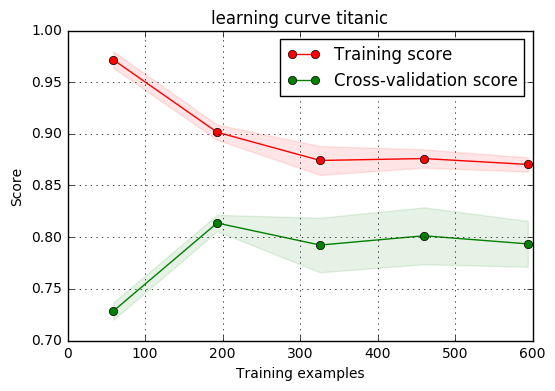

In [84]:
X_df_tr = X_df[90:]
X_df_cv = X_df[0:90]

Y_df_tr = Y_df[90:]
Y_df_cv = Y_df[0:90]

from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
import matplotlib.pyplot as plt
#this function is taken from sk-learn

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


plot_learning_curve(RandomForestClassifier(n_estimators=100), "learning curve titanic", X_df.values, Y_df.values.reshape(891,), ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
#this took a long time. the Y values need to come in in shape form (something, ) and not (something, 1)
plt.show()

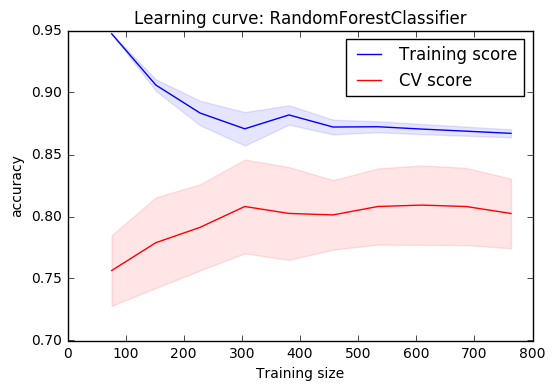

In [85]:
def plot_curve(ticks, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.fill_between(ticks, 
                     train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(ticks, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color="r")
    plt.plot(ticks, train_scores_mean, 'b-', label='Training score')
    plt.plot(ticks, test_scores_mean, 'r-', label='CV score')
    plt.legend()
    return plt.gca()

# Utility to plot the learning curve of a classifier for training set X and target y.
def plot_learning_curve(clf, X, y, scoring='accuracy'):
    ax = plot_curve(*learning_curve(clf, X, y, cv=num_folds, scoring=scoring, 
                                    train_sizes=np.linspace(0.1,1,10), n_jobs=-1))
    ax.set_title('Learning curve: {}'.format(clf.__class__.__name__))
    ax.set_xlabel('Training size')
    ax.set_ylabel(scoring)
    
num_folds = 7    
plot_learning_curve(RandomForestClassifier(n_estimators=100), X_df.values, Y_df.values.reshape(891,))   
plt.show()

It looks like the out of sample accuracy does not increase with training examples here. I'll try overfitting more (the in sample accuracy is not decreasing either ) to see if the out of sample accuracy increases. So my hypothesis is that the algorithm has not learned all there is to learn from the given training examples.

## TODOS and ideas

implement k kross fold validation

handle missing values

do bagging : https://en.wikipedia.org/wiki/Bootstrap_aggregating
        
do a random forest

do discretization of data

use learning curves for evaluation
 - need to make a additional test set for this.
 
lasso?
baysian 